# Preliminary instruction

To follow the code in this chapter, the `yfinance` package must be installed in your environment. If you do not have this installed yet, review Chapter 4 for instructions on how to do so.

# Chapter 8: Position Sizing: Money is Made in the Money Management Module

In [1]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

import pandas as pd
import numpy as np
import yfinance as yf
%matplotlib inline
import matplotlib.pyplot as plt

#### Convexity and concavity accelerate both drop and recovery as shown in the theoretical example below: 

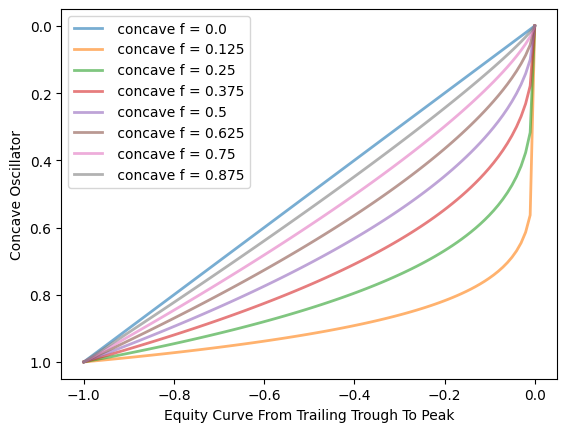

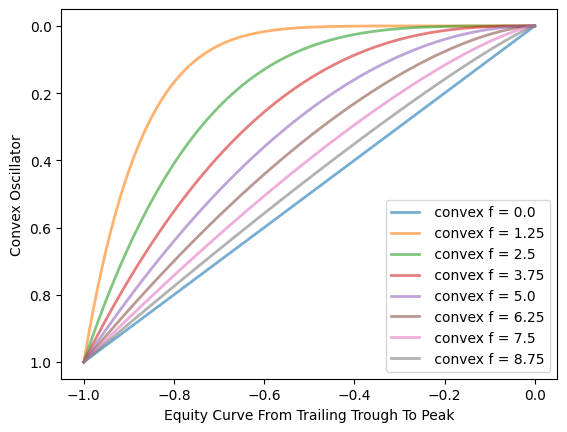

<Figure size 2000x800 with 0 Axes>

In [2]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

def concave(ddr, floor):
    '''
    For demo purpose only
    '''
    if floor == 0:
        concave = ddr
    else:
        concave = ddr ** (floor)
    return concave

# obtuse 
def convex(ddr, floor):
    '''
    obtuse = 1 - acute
    '''
    if floor == 0:
        convex = ddr
    else:
        convex = ddr ** (1/floor)
    return convex

# instantiate minimum Kapital 
floor = np.arange(0,1,0.125)
# print('floor', floor)

x = -np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i,f in enumerate(floor):
    y = concave(ddr=-x, floor=f)
    current_label = f' concave f = {f:.3}'
    ax.plot(x, y, linewidth=2, alpha=0.6, label=current_label)

ax.legend()
plt.ylabel('Concave Oscillator')
plt.xlabel('Equity Curve From Trailing Trough To Peak')
ax.set_ylim(ax.get_ylim()[::-1])
plt.show()

fig, ax = plt.subplots()
for i,f in enumerate(floor):
    y = convex(ddr=-x, floor=f)
    current_label = f' convex f = {f*10:.3}'
    ax.plot(x, y, linewidth=2, alpha=0.6, label=current_label)
ax.legend()

plt.ylabel('Convex Oscillator')
plt.xlabel('Equity Curve From Trailing Trough To Peak')
ax.set_ylim(ax.get_ylim()[::-1])
plt.figure(figsize=(20,8))
plt.show()

#### Equity curve simulation using DAX

Plot:  The equity curve, peak equity, drawdown, and drawdown tolerance band

In [18]:
import logging
import pandas as pd
import os
from typing import Any
from algoshort.regime_fc import RegimeFC
from algoshort.returns import ReturnsCalculator
from algoshort.stop_loss import StopLossCalculator   # your stop-loss module
from algoshort.position_sizing import PositionSizing  # your position sizing module
from algoshort.utils import load_config
from algoshort.optimizer import get_equity, StrategyOptimizer
import numpy as np
from algoshort.yfinance_handler import YFinanceDataHandler
from algoshort.ohlcprocessor import OHLCProcessor

# download data
handler = YFinanceDataHandler(cache_dir="./cache")
# handler.download_data(['MONC.MI', 'FTSEMIB.MI'], start='2016-01-01', end=date.today(), use_cache=True)
handler.download_data(['^GDAXI'], start='2017-12-31', end='2021-07-14', use_cache=False)
df = handler.get_ohlc_data('^GDAXI')
df['fx'] = 1
df.set_index('date')
# bmk = handler.get_ohlc_data('FTSEMIB.MI')

# df.columns.name = None
# bmk.columns.name = None

# # get relative price
# processor = OHLCProcessor()
# df = processor.calculate_relative_prices(
#     stock_data= df,
#     benchmark_data= bmk
#     )

2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,539 - INFO - Cache hits: 0, Downloads needed: 1
2026-01-17 15:51:06,562 - algoshort.yfinance_handler.YFinanceDataHandler - INFO - Downloading 1 symbols in 1 chun

,open,high,low,close,fx
date,,,,,
2018-01-02 00:00:00+01:00,12897.690430,12924.160156,12745.150391,12871.389648,1
2018-01-03 00:00:00+01:00,12916.179688,13023.589844,12893.049805,12978.209961,1
2018-01-04 00:00:00+01:00,13065.980469,13208.349609,13062.669922,13167.889648,1
2018-01-05 00:00:00+01:00,13219.110352,13332.799805,13219.110352,13319.639648,1
2018-01-08 00:00:00+01:00,13399.620117,13407.820312,13334.160156,13367.780273,1
...,...,...,...,...,...
2021-07-07 00:00:00+02:00,15606.940430,15700.950195,15604.580078,15692.709961,1
2021-07-08 00:00:00+02:00,15584.719727,15591.650391,15304.410156,15420.639648,1
2021-07-09 00:00:00+02:00,15497.929688,15687.929688,15479.440430,15687.929688,1


In [29]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

ticker = '^GDAXI'
dd_tolerance = -0.1

equity = pd.DataFrame()
equity['equity'] =  df['close']
equity['date'] = pd.to_datetime(df['date'])
equity = equity.set_index('date')
equity['peak_equity'] = equity['equity'].cummax()
equity['tolerance'] = equity['peak_equity'] * (1 + dd_tolerance )
equity['drawdown'] = equity['equity'] /equity['equity'].cummax() -1
# equity
equity.index = equity.index.tz_localize(None)

# equity['ddr'] = 1 - np.minimum(equity['drawdown'] / dd_tolerance,1) # drawdown rebased to tolerance from 0 to 1
# equity['avg_ddr'] = equity['ddr'].ewm(span = 5).mean() # span rebased drawdown
# equity.head(10)

Text(0.5, 0, 'date')

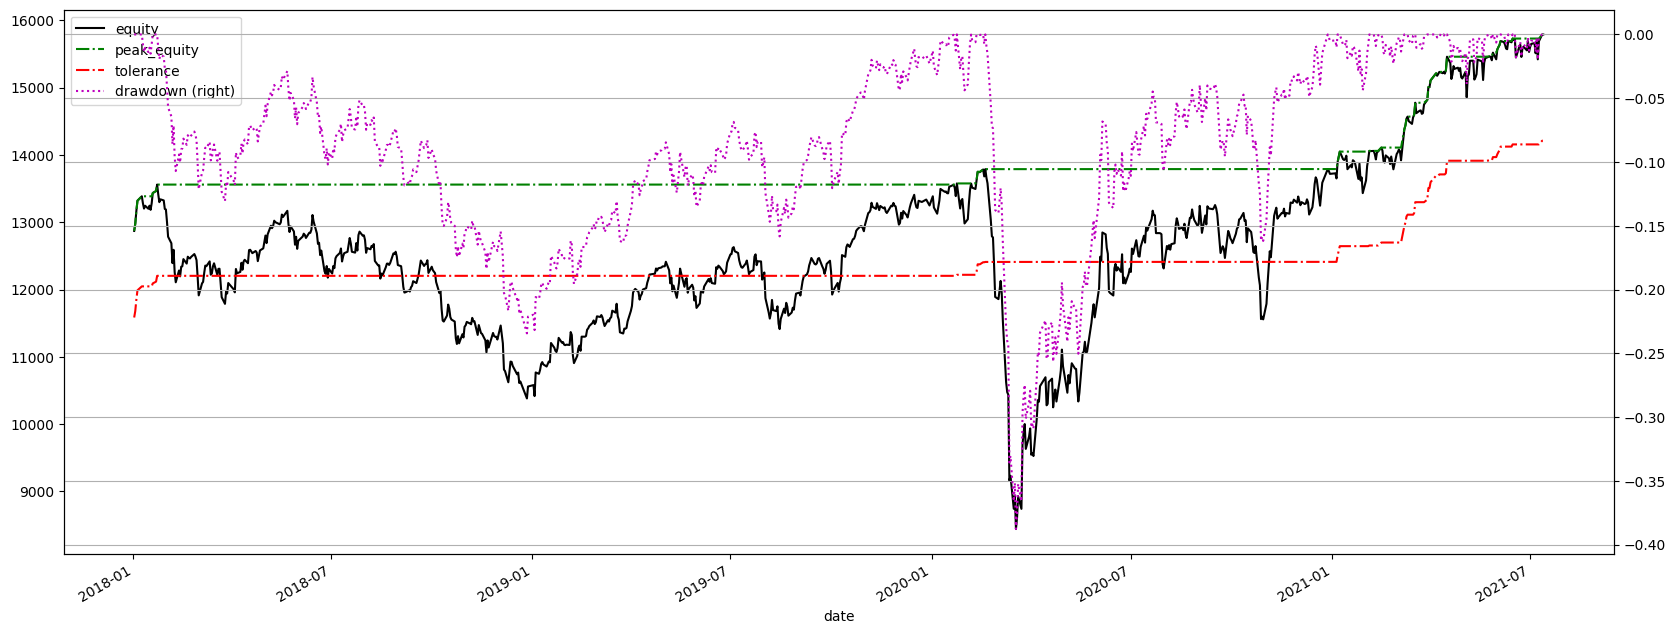

In [ ]:




equity.to_excel('GDAXI.xlsx')
ax =equity.plot(style = ['k','g-.','r-.','m:'] ,
            secondary_y=['drawdown'], figsize=(20,8),grid=True)
ax.set_xlabel("date")

### Equity Risk Oscillator

1. Calculate peak equity, watermark, from the eqty series.
2. Calculate drawdown and rebased drawdown using drawdown tolerance. Smooth the average rebased drawdown using an exponential moving average.
3. Choose the shape of the curve: concave (-1), convex (1), or linear (anything else).
4. Calculate the risk appetite oscillator.

In [20]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

def risk_appetite(eqty, tolerance, mn, mx, span, shape):
    '''
    eqty: equity curve series
    tolerance: tolerance for drawdown (<0)
    mn: min risk
    mx: max risk
    span: exponential moving average to smoothe the risk_appetite
    shape: convex (>45 deg diagonal) = 1, concave (<diagonal) = -1, else: simple risk_appetite
    '''
    # drawdown rebased
    eqty = pd.Series(eqty)
    watermark = eqty.expanding().max() # all-time-high peak equity
    drawdown = eqty / watermark - 1 # drawdown from peak
    ddr = 1 - np.minimum(drawdown / tolerance,1) # drawdown rebased to tolerance from 0 to 1
    avg_ddr = ddr.ewm(span = span).mean() # span rebased drawdown
    
    # Shape of the curve
    if shape == 1: # 
        _power = mx/mn # convex 
    elif shape == -1 :
        _power = mn/mx # concave
    else:
        _power = 1 # raw, straight line
    ddr_power = avg_ddr ** _power # ddr 
    
    # mn + adjusted delta
    risk_appetite = mn + (mx - mn) * ddr_power 
    
    return risk_appetite


#### Position sizing functions
1. peak_equity: calculate all-time-high watermark
2. risk_budget: watermark * risk appetite * currency adjusmtent
3. risk_unit: price - stop_loss, R in Van Tharp's terminology
4. shares_roundlot: round lot shares traded
5. target_price: cost + r * r_multiplier
6. partial_exit: quantity / r_multiplier

In [21]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

def peak_equity(eqty):
    '''
    calculates peak equity
    
    '''
    equity = pd.Series(eqty)
    peak = equity.expanding().max()
    return peak


def risk_budget(eqty,appetite,fx):
    '''
    eqty: eqty to be deployed. Deault at peak equity
    risk_appetite: risk to allocate to  
    fx: currency conversion
    '''
    budget = peak_equity(eqty) * appetite * fx
    return budget

def risk_unit(price,stop_loss):
    '''
    Van Tharp's R: distance to stop loss in $
    '''
    r = price - stop_loss
    return r 

def shares_roundlot(budget,fx,r,lot):
    fx_budget = fx * budget
    rounded_shares = fx_budget // (r * lot)
    shares = rounded_shares * lot
    return shares

def target_price(price, stop_loss, r_multiplier):
    r = price - stop_loss
    return price + r * r_multiplier

def partial_exit(qty, r_multiplier):
    if (qty * r_multiplier)!= 0:
        fraction = qty / r_multiplier
    else:
        fraction = 0
    return fraction

#### DAX equity curve, peak, and drawdown tolerance. Concave, convex, and constant equity at risk

3 levels of risk: 
1. minimum at –0.25, 
2. maximum at –0.75% 
3. average at –0.50%. Average risk is the constant equity at risk


Plot: The equity curve, peak, and drawdown tolerance. Concave, convex, and constant equity at risk

Plot: The drawdown, concave, convex, and constant equity at risk

In [36]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

eqty= equity['equity']
tolerance= dd_tolerance
mn= -0.0025 
mx= -0.0075 
avg = (mn + mx)/2
span= 5 
shape = 1
equity['constant_risk'] = -equity['equity'] * avg
equity['rp_convex'] = -risk_appetite(eqty, tolerance, mn, mx, span, shape=1)
equity['rp_concave'] = -risk_appetite(eqty, tolerance, mn, mx, span, shape=-1)
equity['convex_risk'] = equity['rp_convex'] * equity['peak_equity'] 
equity['concave_risk'] = equity['rp_concave'] * equity['peak_equity'] 

equity.reset_index()
equity.head(30)

,equity,peak_equity,tolerance,drawdown,constant_risk,convex_risk,concave_risk,rp_convenx,rp_concave,rp_convex
date,,,,,,,,,,
2018-01-02,12871.389648,12871.389648,11584.250684,0.000000,64.356948,96.535422,96.535422,0.007500,0.007500,0.007500
2018-01-03,12978.209961,12978.209961,11680.388965,0.000000,64.891050,97.336575,97.336575,0.007500,0.007500,0.007500
2018-01-04,13167.889648,13167.889648,11851.100684,0.000000,65.839448,98.759172,98.759172,0.007500,0.007500,0.007500
2018-01-05,13319.639648,13319.639648,11987.675684,0.000000,66.598198,99.897297,99.897297,0.007500,0.007500,0.007500
2018-01-08,13367.780273,13367.780273,12031.002246,0.000000,66.838901,100.258352,100.258352,0.007500,0.007500,0.007500
2018-01-09,13385.589844,13385.589844,12047.030859,0.000000,66.927949,100.391924,100.391924,0.007500,0.007500,0.007500
2018-01-10,13281.339844,13385.589844,12047.030859,-0.007788,66.406699,95.006648,99.771010,0.007098,0.007454,0.007098
2018-01-11,13202.900391,13385.589844,12047.030859,-0.013648,66.014502,88.109295,98.901020,0.006582,0.007389,0.006582
2018-01-12,13245.030273,13385.589844,12047.030859,-0.010501,66.225151,85.763180,98.582737,0.006407,0.007365,0.006407


<Axes: xlabel='date'>

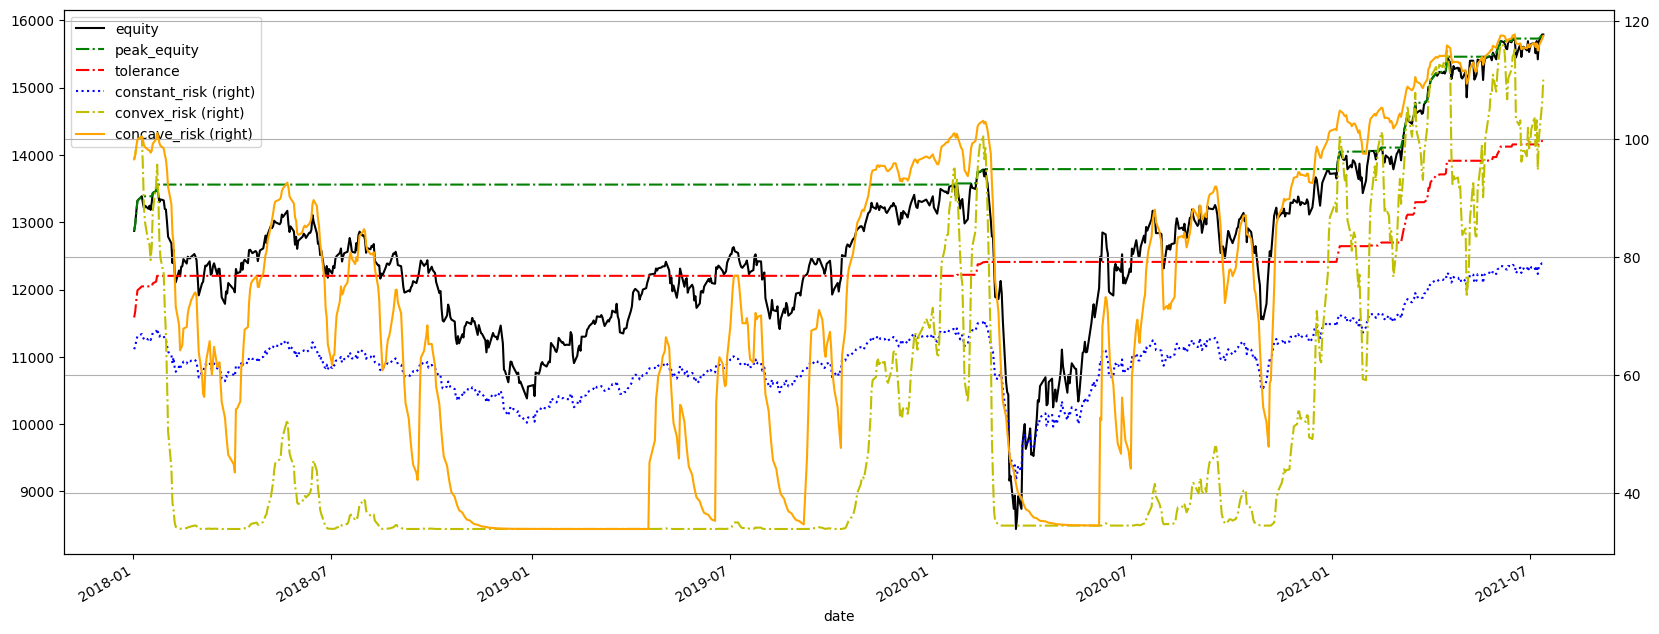

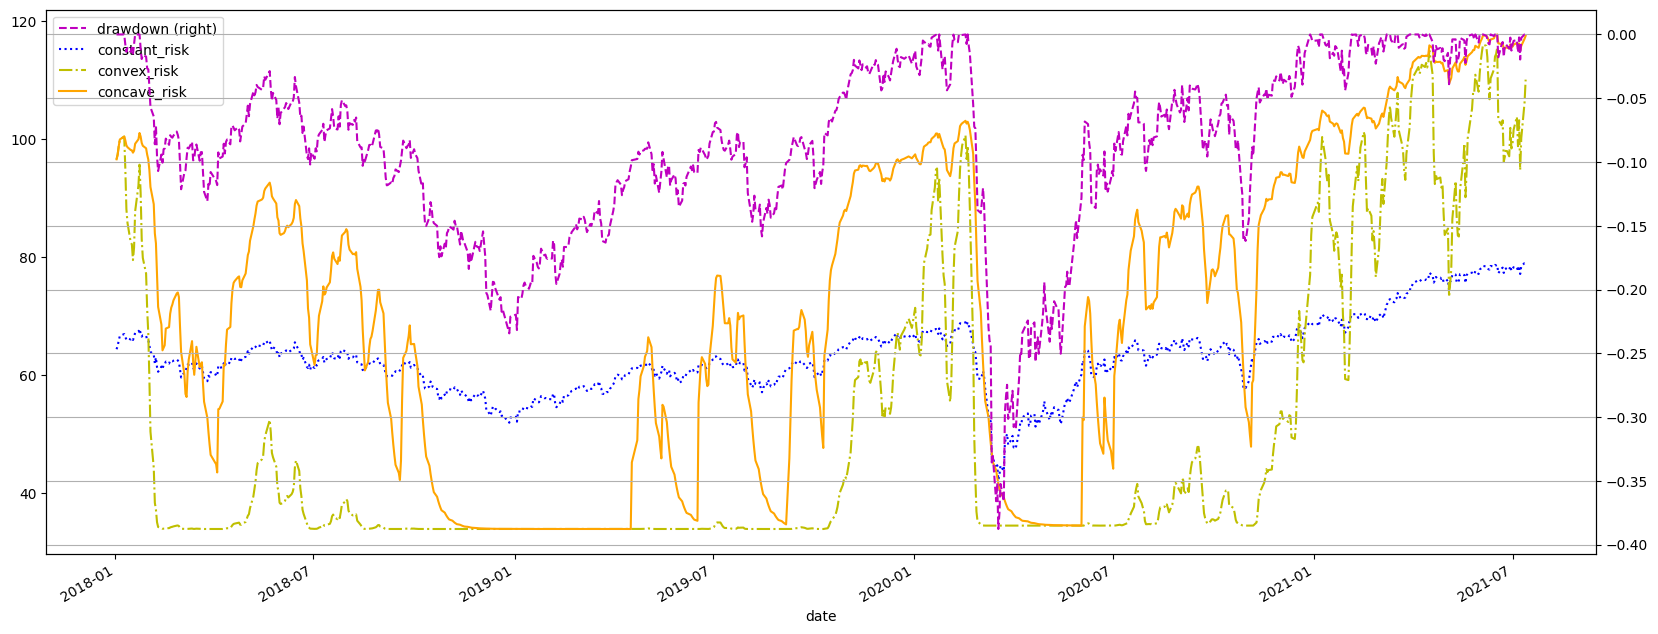

In [32]:
equity[['equity', 'peak_equity', 'tolerance',
        'constant_risk','convex_risk','concave_risk']].plot(figsize= (20,8),grid=True,
    secondary_y=['constant_risk','convex_risk','concave_risk'],
    style= ['k','g-.','r-.','b:','y-.', 'orange'])

equity[['drawdown','constant_risk','convex_risk','concave_risk']].plot(grid=True,
    secondary_y=['drawdown'],style= ['m--','b:','y-.', 'orange'], figsize= (20,8) )

#### Mock strategy 

In [12]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

def regime_breakout(df,_h,_l,window):
    hl =  np.where(df[_h] == df[_h].rolling(window).max(),1,
                                np.where(df[_l] == df[_l].rolling(window).min(), -1,np.nan))
    roll_hl = pd.Series(index= df.index, data= hl).fillna(method= 'ffill')
    return roll_hl

def turtle_trader(df, _h, _l, slow, fast):
    '''
    _slow: Long/Short direction
    _fast: trailing stop loss
    '''
    _slow = regime_breakout(df,_h,_l,window = slow)
    _fast = regime_breakout(df,_h,_l,window = fast)
    turtle = pd. Series(index= df.index, 
                        data = np.where(_slow == 1,np.where(_fast == 1,1,0), 
                                np.where(_slow == -1, np.where(_fast ==-1,-1,0),0)))
    return turtle

#### Softbank closing price, long/short positions, using Turtle for dummies on absolute series

1. Softbank closing price, long/short positions, using Turtle for dummies on absolute series
2. Strategy daily profit and loss in local currency and USD
3. Strategy cumulative profit and loss in local currency and USD


In [15]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'fx', 'ropen', 'rhigh', 'rlow',
       'rclose', 'rhi_50', 'rlo_50', 'rhi_10', 'rlo_10', 'rbo_50', 'rbo_10',
       'rtt_5010'],
      dtype='object')

<Axes: title={'center': '9984.T Daily P&L & Cumulative P&L'}>

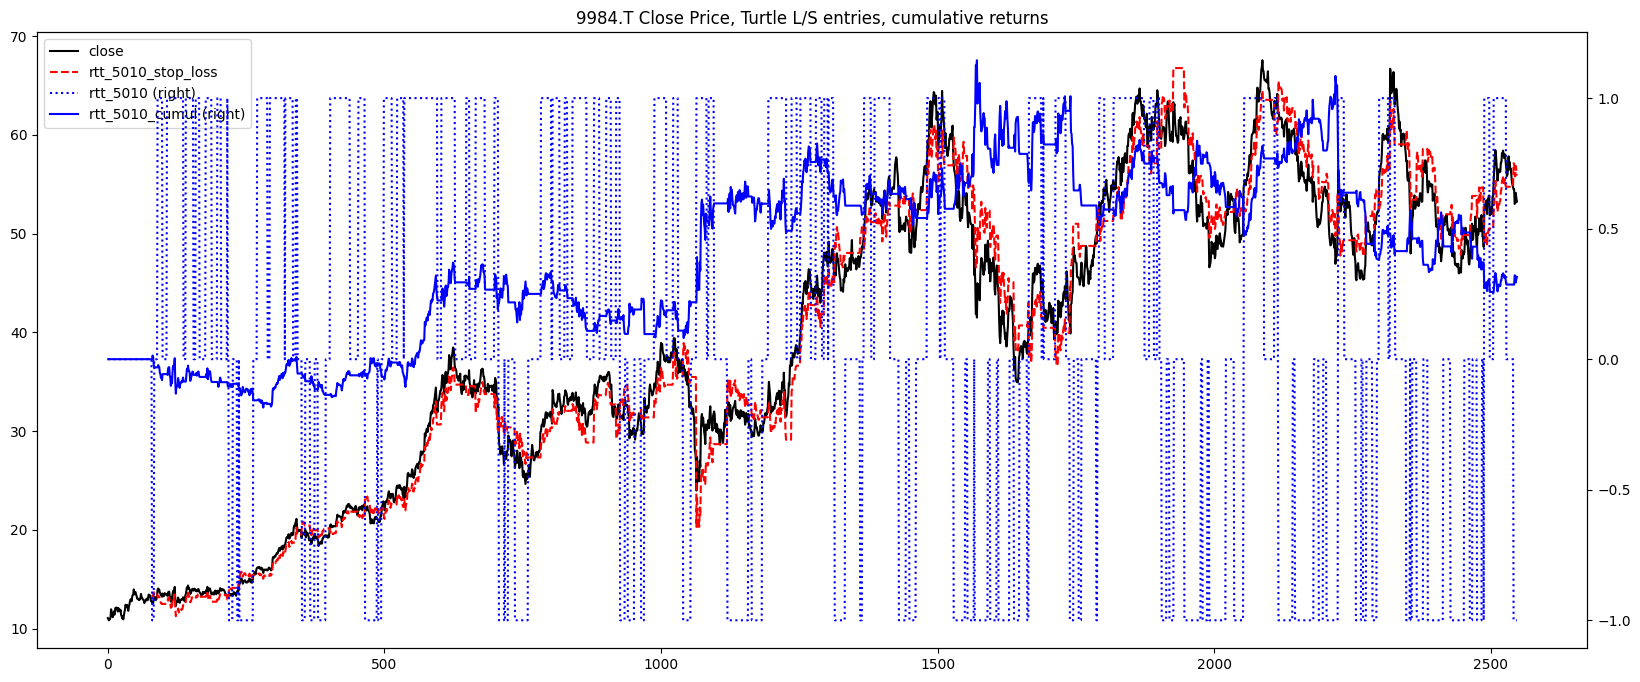

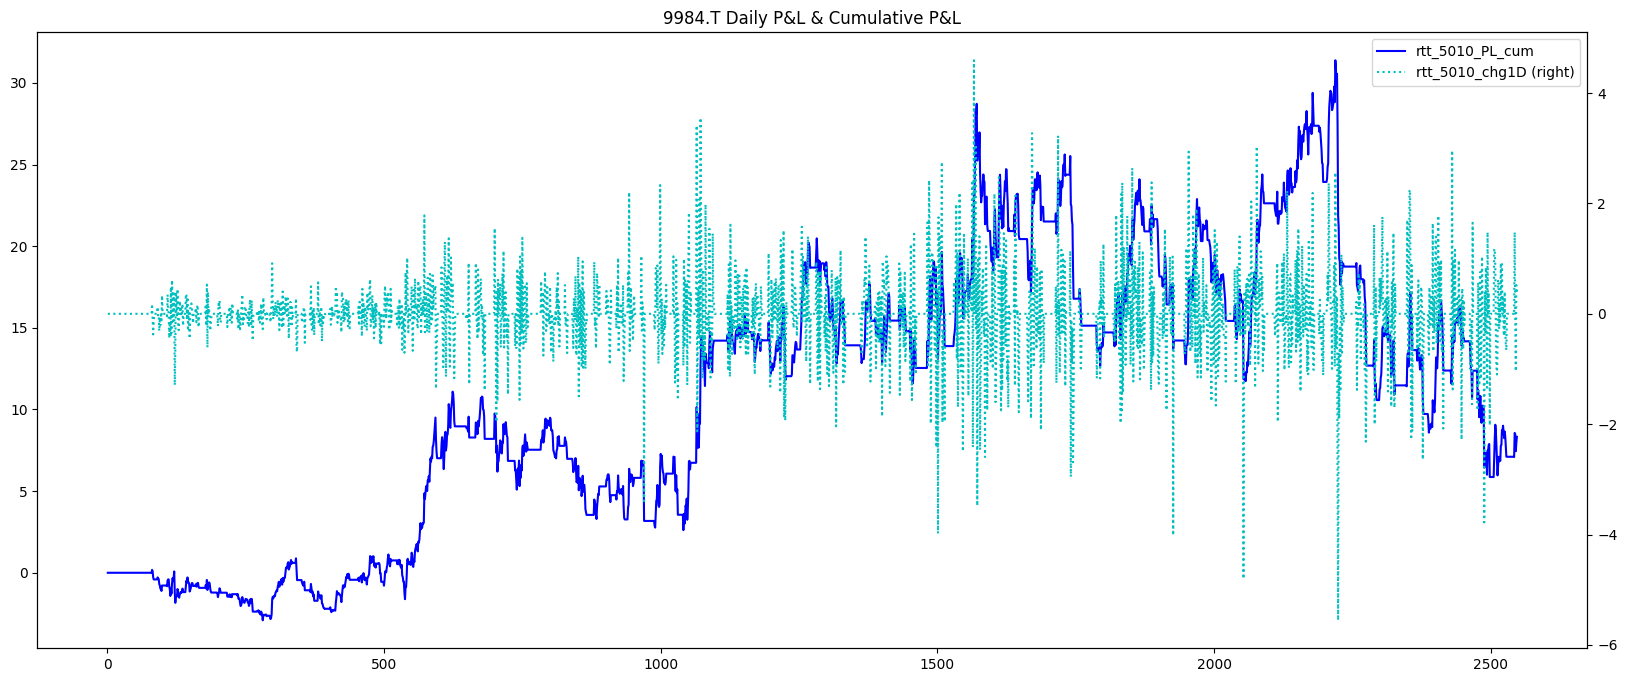

In [17]:
from algoshort.regime_bo import RegimeBO
regime_bo = RegimeBO(ohlc_stock=df)
df = regime_bo.compute_regime(regime_type='turtle', fast_window=10,
                             window=50,
                             relative=True, inplace=False)

# calculate stop loss
from algoshort.stop_loss import StopLossCalculator
sl = StopLossCalculator(df)
df = sl.atr_stop_loss(
    signal='rtt_5010',
    price_col='close'
)

from algoshort.wrappers import calculate_return
df = calculate_return(df, config_path='./config.json', signal_columns=['rtt_5010'])


df[['close','rtt_5010_stop_loss','rtt_5010','rtt_5010_cumul']].plot(secondary_y=['rtt_5010','rtt_5010_cumul'],
                                  figsize=(20,8),style= ['k','r--','b:','b'],
                       title= str(ticker)+' Close Price, Turtle L/S entries, cumulative returns')

df[['rtt_5010_PL_cum','rtt_5010_chg1D']].plot(secondary_y=['rtt_5010_chg1D'],
                                  figsize=(20,8),style= ['b','c:'],
                                 title= str(ticker) +' Daily P&L & Cumulative P&L')

#### Equity at risk shares

In [9]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

def eqty_risk_shares(px,sl,eqty,risk,fx,lot):
    r = sl - px
    if fx > 0:
        budget = eqty * risk * fx
    else:
        budget = eqty * risk
    shares = round(budget // (r *lot) * lot,0)
#     print(r,budget,round(budget/r,0))
    return shares

px = 2000
sl = 2222

eqty = 100000
risk = -0.005
fx = 110
lot = 100

eqty_risk_shares(px,sl,eqty,risk,fx,lot)

-300.0

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
C:\Users\l_ace\AppData\Local\Temp\ipykernel_8680\827192510.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[ccy_name] = df[ccy_name].fillna(method='ffill')
C:\Users\l_ace\AppData\Local\Temp\ipykernel_8680\383032766.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  roll_hl = pd.Series(index= df.index, data= hl).fillna(method= 'ffill')


<Axes: title={'center': '9984.T Cumulative P&L Local & USD'}, xlabel='Date'>

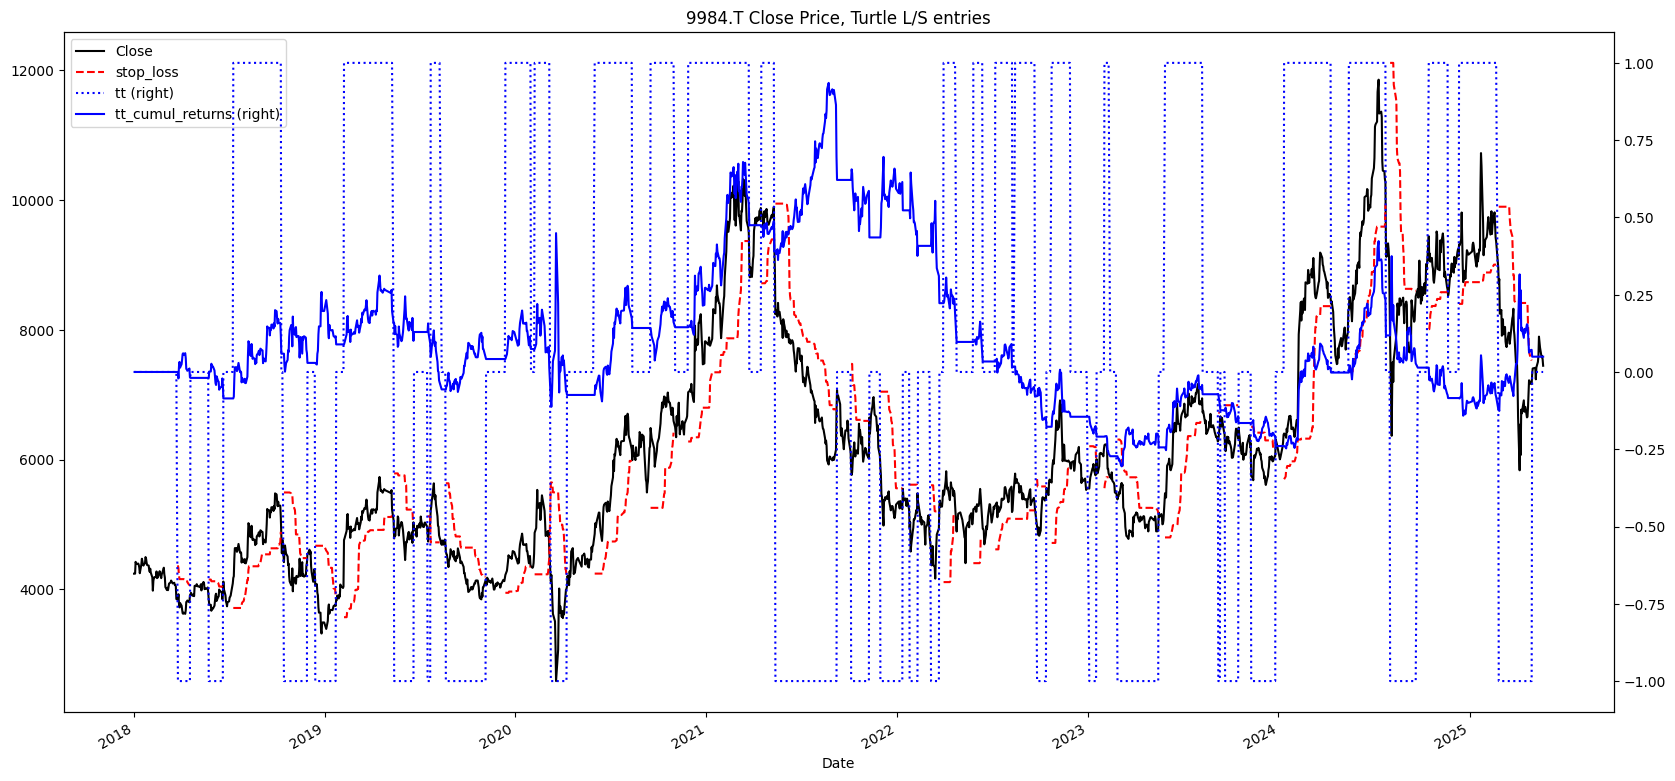

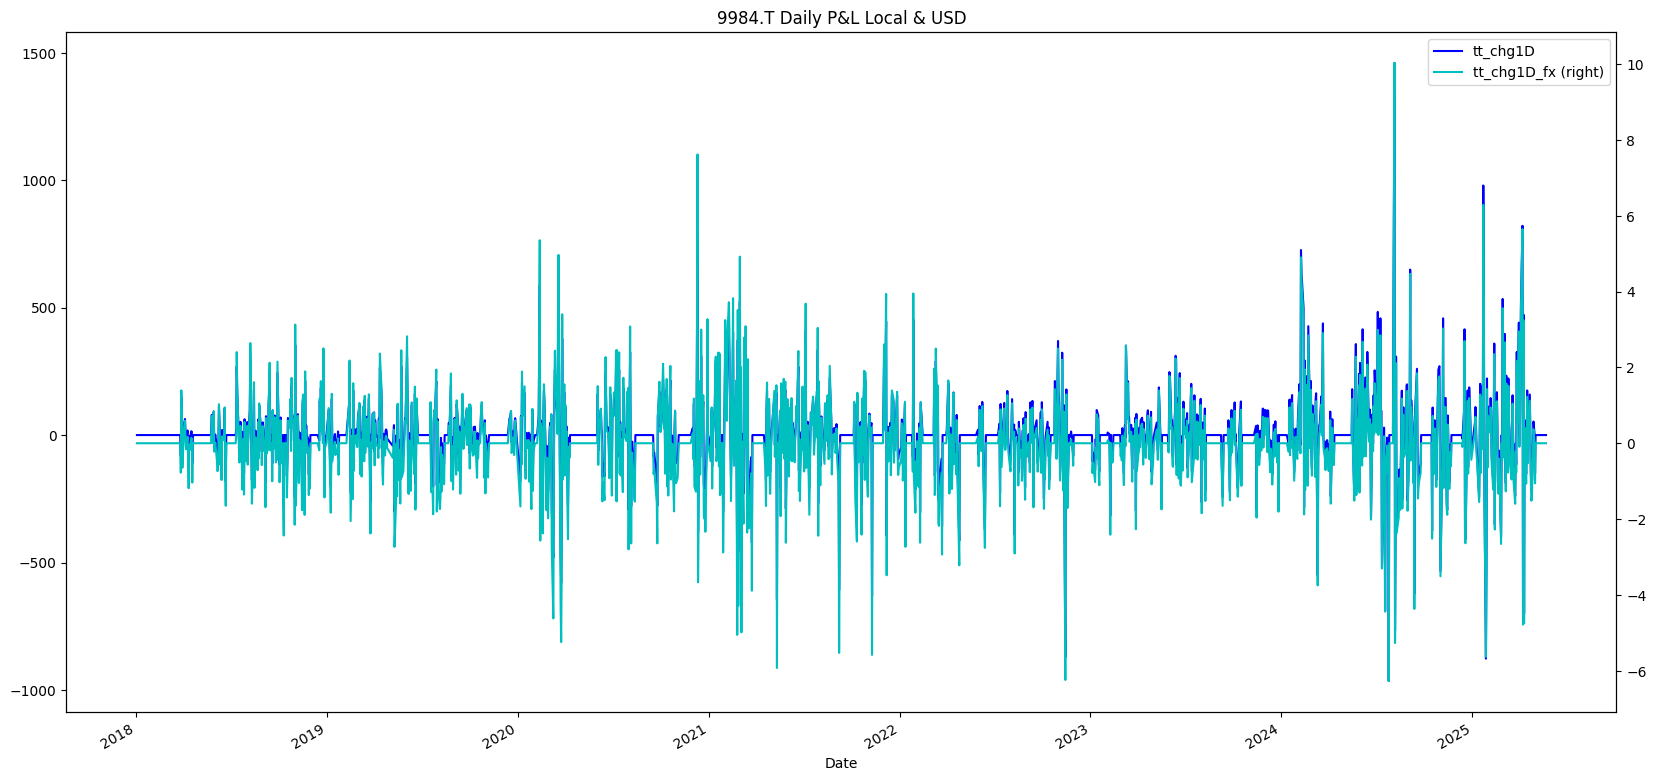

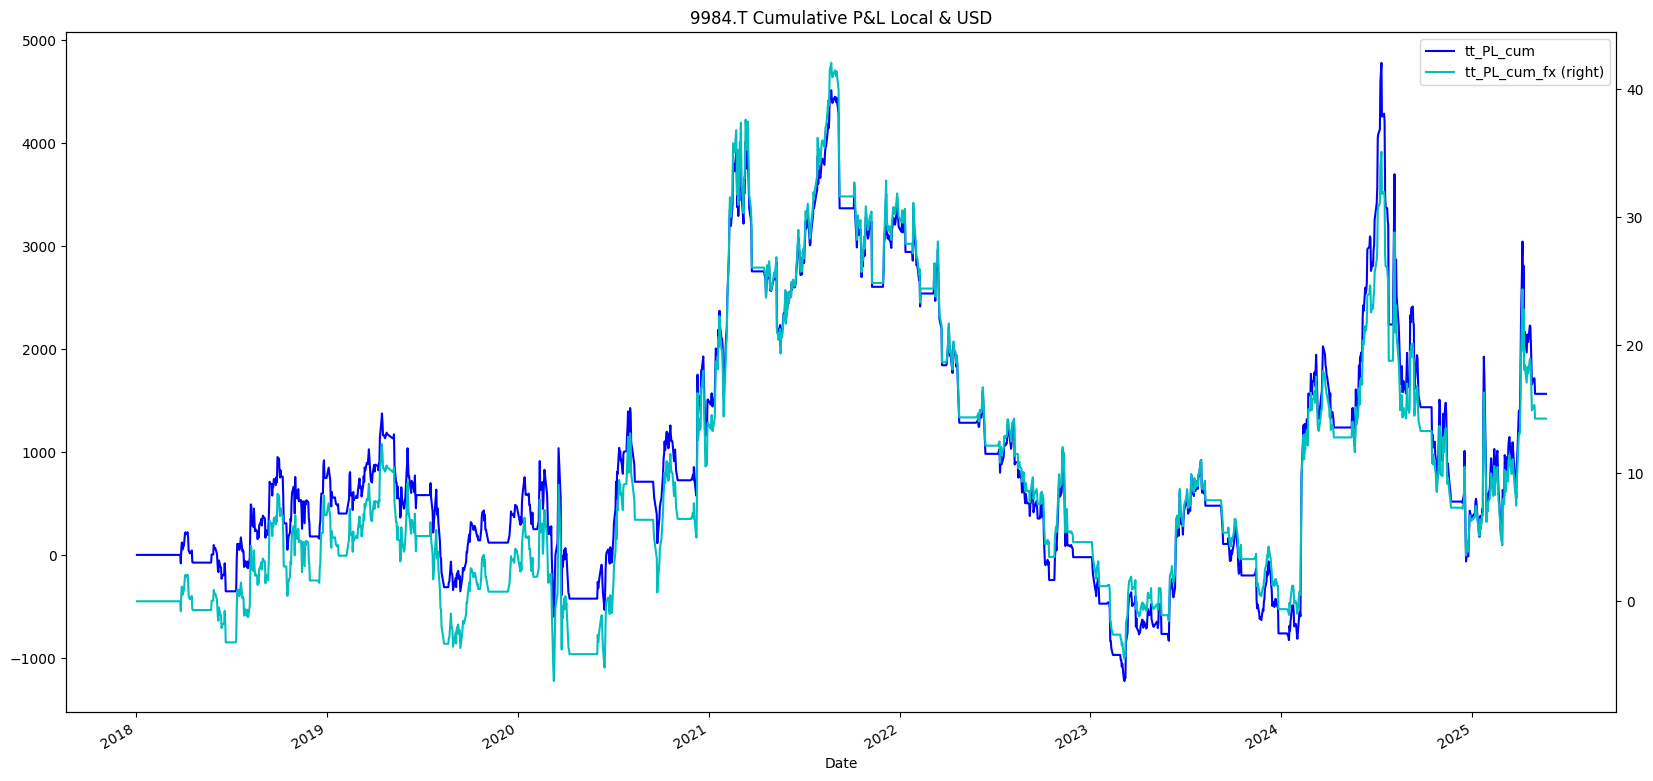

In [10]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

# NEW CODE WITH WORKING LIBRARY
ticker = '9984.T' # Softbank
start = '2017-12-31'
end = None
df =  round(yf.download(tickers= ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, threads = True, proxy = None, multi_level_index=False),0)

ccy_ticker = 'USDJPY=X'
ccy_name = 'JPY'
ccy_df = np.nan

df[ccy_name] =  round(yf.download(tickers= ccy_ticker,start= start, end = end, 
                        interval = "1d",group_by = 'column',auto_adjust = True, 
                              prepost = True, threads = True, proxy = None, multi_level_index=False)['Close'],2)
df[ccy_name] = df[ccy_name].fillna(method='ffill')
slow = 50
fast = 20 
df['tt'] = turtle_trader(df, _h= 'High', _l= 'Low', slow= slow,fast= fast)
df['tt_chg1D'] = df['Close'].diff() * df['tt'].shift()
df['tt_chg1D_fx'] = df['Close'].diff() * df['tt'].shift() / df[ccy_name]

df['tt_returns'] = df['Close'].pct_change() * df['tt'].shift()
df['tt_log_returns'] = np.log(df['Close'] / df['Close'].shift()) * df['tt'].shift()
df['tt_cumul_returns'] = df['tt_log_returns'].cumsum().apply(np.exp) - 1 

df['stop_loss'] = np.where(df['tt'] == 1, df['Low'].rolling(fast).min(),
                    np.where(df['tt'] == -1, df['High'].rolling(fast).max(),np.nan))# / df[ccy_name]
df['tt_PL_cum'] = df['tt_chg1D'].cumsum()
df['tt_PL_cum_fx'] = df['tt_chg1D_fx'].cumsum()


df[['Close','stop_loss','tt','tt_cumul_returns']].plot(secondary_y=['tt','tt_cumul_returns'],
                                  figsize=(20,10),style= ['k','r--','b:','b'],
                       title= str(ticker)+' Close Price, Turtle L/S entries')

df[['tt_chg1D','tt_chg1D_fx']].plot(secondary_y=['tt_chg1D_fx'],
                                  figsize=(20,10),style= ['b','c'],
                                 title= str(ticker) +' Daily P&L Local & USD')

df[['tt_PL_cum','tt_PL_cum_fx']].plot(secondary_y=['tt_PL_cum_fx'],
                                  figsize=(20,10),style= ['b','c'],
                                 title= str(ticker) +' Cumulative P&L Local & USD')

### Comparing position-sizing algorithms

The code takes the following steps:
1. Instantiate parameters: starting capital, currency, minimum and maximum risk, drawdown tolerance and equal weight
2. Initialize the number of shares & starting capital for each posSizer
3. Loop through every bar to recalculate every equity curve by adding the previous value to the current number of shares times daily profit.
4. Recalculate the concave and convex risk oscillator at each bar.
5. If there is an entry signal, calculate the number of shares for each posSizer. 

C:\Users\l_ace\AppData\Local\Temp\ipykernel_8680\3874774627.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['equal_weight'].iat[i] = df['equal_weight'].iat[i-1] + df['tt_chg1D_fx'][i] * shs_eql
C:\Users\l_ace\AppData\Local\Temp\ipykernel_8680\3874774627.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['constant'].iat[i] = df['constant'].iat[i-1] + df['tt_chg1D_fx'][i] * shs_fxd
C:\Users\l_ace\AppData\Local\Temp\ipykernel_8680\3874774627.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with D

<Axes: title={'center': 'cumulative P&L, concave, convex, constant equity at risk, equal weight '}, xlabel='Date'>

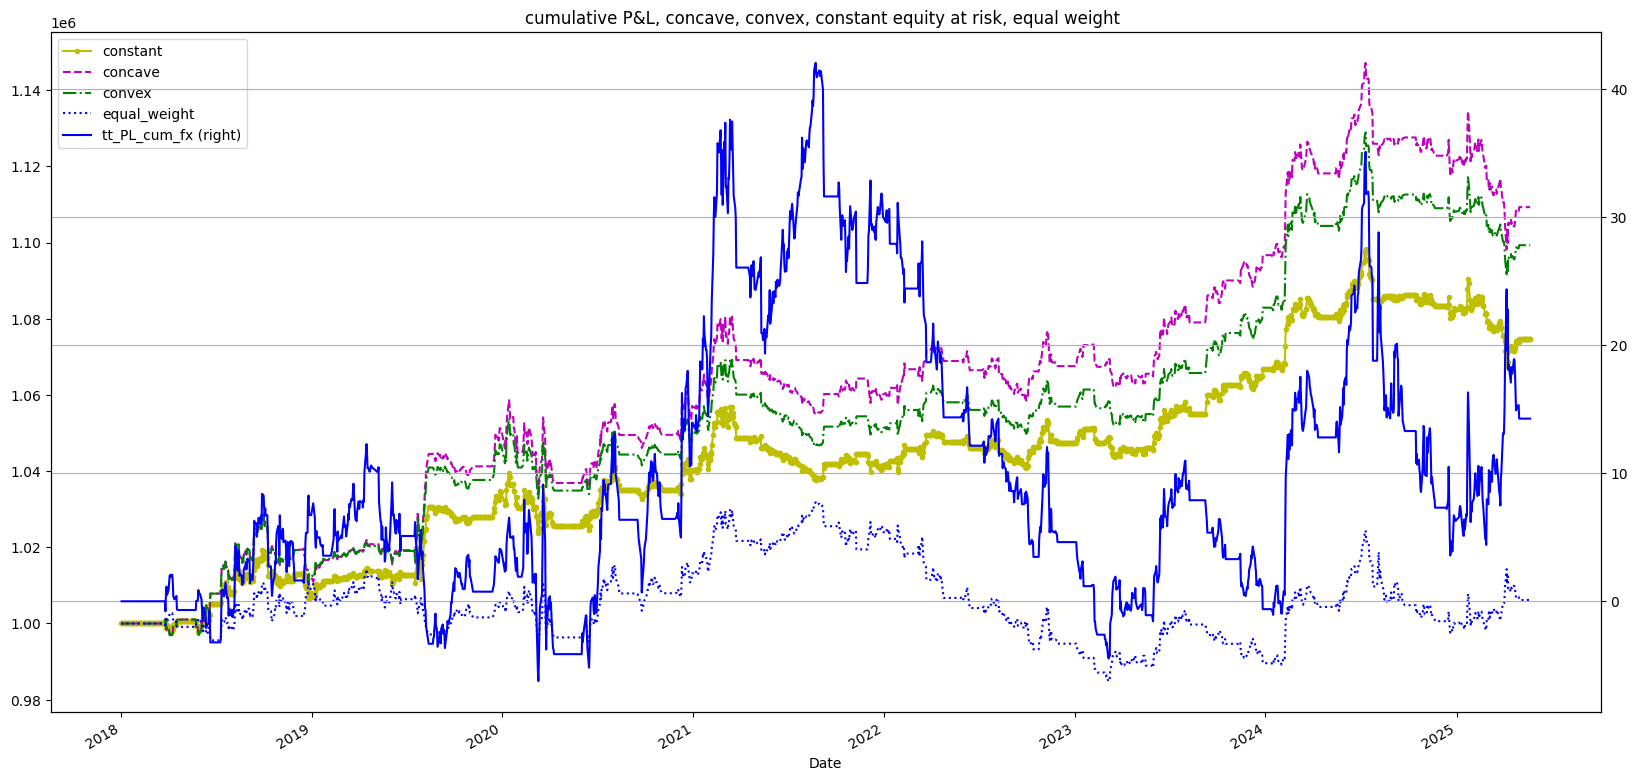

In [11]:
# Chapter 8: Position Sizing: Money is Made in the Money Management Module

starting_capital = 1000000
lot = 100
mn = -0.0025
mx = -0.0075
avg = (mn + mx) / 2
tolerance= -0.1
equal_weight = 0.05
shs_fxd = shs_ccv = shs_cvx = shs_eql = 0
df.loc[df.index[0],'constant'] = df.loc[df.index[0],'concave'] = starting_capital
df.loc[df.index[0],'convex'] = df.loc[df.index[0],'equal_weight'] = starting_capital

for i in range(1,len(df)):
    df['equal_weight'].iat[i] = df['equal_weight'].iat[i-1] + df['tt_chg1D_fx'][i] * shs_eql
    df['constant'].iat[i] = df['constant'].iat[i-1] + df['tt_chg1D_fx'][i] * shs_fxd
    df['concave'].iat[i] = df['concave'].iat[i-1] + df['tt_chg1D_fx'][i] * shs_ccv
    df['convex'].iat[i] = df['convex'].iat[i-1] + df['tt_chg1D_fx'][i] * shs_cvx
    
    ccv = risk_appetite(eqty= df['concave'][:i], tolerance=tolerance, 
                        mn= mn, mx=mx, span=5, shape=-1)
    cvx = risk_appetite(eqty= df['convex'][:i], tolerance=tolerance, 
                        mn= mn, mx=mx, span=5, shape=1)

    if (df['tt'][i-1] ==0) & (df['tt'][i] !=0):
        px = df['Close'][i]
        sl = df['stop_loss'][i]
        fx  = df[ccy_name][i]
        shs_eql = (df['equal_weight'].iat[i]  * equal_weight  *fx//(px * lot)) * lot
        if px != sl:
            shs_fxd = eqty_risk_shares(px,sl,eqty= df['constant'].iat[i],
                                        risk= avg,fx=fx,lot=100)
            shs_ccv = eqty_risk_shares(px,sl,eqty= df['concave'].iat[i],
                                            risk= ccv[-1],fx=fx,lot=100)
            shs_cvx = eqty_risk_shares(px,sl,eqty= df['convex'].iat[i],
                                            risk= cvx[-1],fx=fx,lot=100)

df[['constant','concave','convex','equal_weight', 'tt_PL_cum_fx']].plot(figsize = (20,10), grid=True,
    style=['y.-','m--','g-.','b:', 'b'],secondary_y='tt_PL_cum_fx',
title= 'cumulative P&L, concave, convex, constant equity at risk, equal weight ')

#### Risk amortization

In [12]:
def pyramid(position, root=2): 
    ''' 
    position is the number of positions 
    power is root n.  

    Conservative = 1, aggressive = position, default = 2 
    ''' 
    return 1 / (1+position) ** (1/root) 
 
def amortized_weight(raw_weight, amortization): 
    ''' 
    raw_weight is the initial position size 
    amortization is pyramid(position,root=2) 
    ''' 
    return raw_weight * amortization 

In [13]:

weight = 0.05
position = np.arange(1,4)
print('position',position)
print('linear',pyramid(position, root=1)* weight)
print('square root',pyramid(position, root=2)* weight)
print('position n',pyramid(position, root=position)*weight)

position [1 2 3]
linear [0.025      0.01666667 0.0125    ]
square root [0.03535534 0.02886751 0.025     ]
position n [0.025      0.02886751 0.03149803]
